# F1 Championship Tracker

## Introduction
The current set of regulations in Formula 1 has made for an entertaining couple of years of racing. The focus of the 2022 regulation changes was to promote closer racing. This was achieved mainly by simplifying the bodywork and reintroducing ground-effect aerodynamics, allowing teams to use complex floor designs to generate downforce. These changes reduced turbulent air behind cars, enabling drivers to follow each other more closely and increasing overtaking opportunities.

Currently, one of the most talked-about teams is McLaren, who finished 2022 in 5th place in the Constructors' Championship but have shown significant improvement since then. They have been closing the gap to Red Bull and, after the Azerbaijan Grand Prix this year, overtook them to take the lead in the constructors championship. This project aims to contextualise just how much they've improved.

To do this I'll be getting data from the official F1 website (www.formula1.com) and making use of the libraries below:
- requests: Used to retrieve HTML content from the various webpages.
- BeautifulSoup: Used to extract specific elements within the HTML such as tables and rows.
- pandas: Used for data manipulation and analysis. Specifically creating dataframes, merging information from multiple tables and grouping data to calculate statistics such as the mean race position and total wins.
- urllib.parse: Used to parse the various URLs and decode specific elements.
- Seaborn: Used to create visualisations once the data has been transformed.
- matplotlib: Used to adjust the size of graphs produced using Seaborn.

In [217]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from urllib.parse import urlparse, unquote
import seaborn as sns
import matplotlib.pyplot as plt

## Creating functions to manipulate existing data

One piece of information that isn't available on the official website is the data on engine suppliers. After reviewing 'https://www.formula1.com/en/results/2024/team', I noticed that the engine supplier is included in the team name. This information can be extracted once the table has been scraped.

To avoid repetition, I created a function to split the 'Team' column and extract the engine supplier. This ensures we capture the supplier information in a structured format.

Upon further inspection, I also found a formatting inconsistency for one driver, 'Zhou Guanyu'. On the 'https://www.formula1.com/en/results/2024/drivers' page, his name is listed as 'Zhou Guanyu', but in the URL leading to his personal page, it appears as 'guanyu zhou'. As this issue is likely to persist, I created a function that swaps the first and last names around. This way, if another driver has a similar problem, the function can be reused to handle the mismatch effectively.

In [218]:
drivers = [
    {'name': 'alexander_albon', 'id': 'ALEALB01'},
    {'name': 'fernando_alonso', 'id': 'FERALO01'},
    {'name': 'valtteri_bottas', 'id': 'VALBOT01'},
    {'name': 'nyck_de_vries', 'id': 'NYCDEV01'},
    {'name': 'pierre_gasly', 'id': 'PIEGAS01'},
    {'name': 'lewis_hamilton', 'id': 'LEWHAM01'},
    {'name': 'nico_hulkenberg', 'id': 'NICHUL01'},
    {'name': 'nicholas_latifi', 'id': 'NICLAF01'},
    {'name': 'charles_leclerc', 'id': 'CHALEC01'},
    {'name': 'kevin_magnussen', 'id': 'KEVMAG01'},
    {'name': 'lando_norris', 'id': 'LANNOR01'},
    {'name': 'esteban_ocon', 'id': 'ESTOCO01'},
    {'name': 'sergio_perez', 'id': 'SERPER01'},
    {'name': 'daniel_ricciardo', 'id': 'DANRIC01'},
    {'name': 'carlos_sainz', 'id': 'CARSAI01'},
    {'name': 'mick_schumacher', 'id': 'MICSCH02'},
    {'name': 'lance_stroll', 'id': 'LANSTR01'},
    {'name': 'yuki_tsunoda', 'id': 'YUKTSU01'},
    {'name': 'max_verstappen', 'id': 'MAXVER01'},
    {'name': 'sebastian_vettel', 'id': 'SEBVET01'},
    {'name': 'guanyu_zhou', 'id': 'GUAZHO01'},
    {'name': 'george_russell', 'id': 'GEORUS01'},
    # 2023 drivers
    {'name': 'oscar_piastri', 'id': 'OSCPIA01'},
    {'name': 'logan_sargeant', 'id': 'LOGSAR01'},
    {'name': 'liam_lawson', 'id': 'LIALAW01'},
    # 2024 drivers
    {'name': 'oliver bearman', 'id': 'OLIBEA01'},
    {'name': 'franco-colapinto', 'id': 'FRACOL01'}
]

# Function to correctly format specific names
def swap_name(driver_name):
    name_swaps = {
        'guanyu zhou': 'zhou guanyu'
    }
    
    # Tranforms the drivers name to lower case
    driver_name_lower = driver_name.lower()
    
    # If a drivers name is in name_swap then it swaps the name otherwise it returns the drivers name
    if driver_name_lower in name_swaps:
        return name_swaps[driver_name_lower]
    else:
        return driver_name

# Function to extract the engine supplier from the team name
def get_engine_supplier(car_name):
    parts = car_name.split()

    return parts[-1]

# Function to remove the engine supplier from the team name
def remove_engine_supplier(car_name):
    parts =  car_name.split()
    result = ' '.join(parts[:-1])
    
    return result

# Function to see if the above function needs to be applied
def remove_engine_supplier_if_needed(df):
    car_list = []
    # If there's a space in the team name then it'll apply that function
    for i in df['Car']:
        if ' ' not in i:
            car_list.append(i)
        elif i == 'Red Bull Racing Honda RBPT':
            car_list.append('Red Bull Racing')
        elif i == 'AlphaTauri Honda RBPT':
            car_list.append('AlphaTauri')
        else:
            car = remove_engine_supplier(i)
            car_list.append(car)
    
    df['Car'] = car_list
    return df

## Creating a function to extract data from the Drivers Championship for any given year

This function was relatively straightforward to create. After inspecting the URL, I realised that everything remained the same except for the year. Initially, as I was still learning how to web scrape, I focused on extracting data for just one year. Once my understanding grew, I expanded the function to loop over any given year.

Within this function, I also utilised the get_engine_supplier function to extract the engine supplier from each team name. Additionally, I created a new column to represent whether a driver finished in the top 10 of the Drivers Championship for that year.

In [219]:
def scrape_driver_standings(year):
    url = f"https://www.formula1.com/en/results/{year}/drivers"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html")
    
    # Finds all the table headers within that webpage
    header = soup.find_all('th')
    table_header = [title.text.strip() for title in header]

    df = pd.DataFrame(columns=table_header)

    # Find the table data
    data = soup.find_all('td')
    table_data = [value.text.strip() for value in data]

    # Reshape the data into rows
    rows = len(table_data) // len(table_header)     # Determine number of rows

    # Create rows from table_data
    table_rows = [table_data[i * len(table_header):(i + 1) * len(table_header)] for i in range(rows)]

    # Add the rows to the DataFrame
    for row in table_rows:
        df.loc[len(df)] = row       # Append each row to the DataFrame

    # Remove driver abbreviation from Driver column
    df['Driver'] = df['Driver'].str[:-3]
    df['Driver'] = df['Driver'].str.replace('\xa0', ' ')
    df['Driver'] = df['Driver'].str.lower().str.strip().str.replace('_', ' ')

    # Get the engine supplier from the Car column
    df['Engine Supplier'] = df['Car'].apply(get_engine_supplier)

    remove_engine_supplier_if_needed(df)        # Shorten the team name

    df['Year'] = year

    df['Pts'] = df['Pts'].astype(int)

    # This is a new column to show if a driver is in the top half of the table
    Top_10 = []
    
    for i in df['Pos']:
        if int(i) <= 10:
            Top_10.append(1)
        else:
            Top_10.append(0)

    df['Top 10'] = Top_10

    driver_table = df
    return driver_table

## Creating a function to retrieve and clean the results for every driver in any given year

This part of the process is slightly more complex, as it requires a list of drivers along with their unique driver IDs, which are extracted from the URL of each driver's page. For example, in the URL 'https://www.formula1.com/en/results/2024/drivers/GUAZHO01/guanyu-zhou', the 'GUAZHO01' part is the driver ID for Guanyu Zhou.

The process for extracting the data is similar to scraping the Drivers Championship standings, but we use the driver ID to access the specific race results for each driver over the course of the season.

In [220]:
def scrape_race_results(year,drivers):
    base_url = f"https://www.formula1.com/en/results/{year}/drivers/{{}}/{{}}"

    rows_list = []

    for driver in drivers:
        driver_name = driver['name']
        driver_id = driver['id']
        
        # Create the URL for the current driver
        url = base_url.format(driver_id, driver_name)
    
        # Send the request to the URL
        page = requests.get(url)
        soup = BeautifulSoup(page.text, "html")
        
        # Find all rows in the table
        rows = soup.find_all('tr')
        
        # Get race position and points for each row skipping the table header
        for row in rows[1:]:
            td = row.find_all('td')

            race_date = td[1].text.strip()      # Only extracting the data needed
            circuit = td[0].text.strip()
            car = td[2].text.strip()
            race_position = td[-2].text.strip()
            points = td[-1].text.strip()
            
            # Preparing the data to be added to the rows_list
            row_data = {'Driver': driver_name.replace('_', ' ').title(),
                        'Circuit': circuit,
                        'Car': car,
                        'Date': race_date,
                        'Race Position': race_position, 
                        'PTS': int(points)}
            
            rows_list.append(row_data)


    # Convert the list of dictionaries to a DataFrame
    results_df = pd.DataFrame(rows_list, columns=['Driver', 'Circuit', 'Car', 'Date', 'Race Position', 'PTS'])

    results_df['Driver'] = results_df['Driver'].str.replace('\xa0', ' ')
    results_df['Driver'] = results_df['Driver'].str.lower().str.strip().str.replace('_', ' ')
    results_df['Driver'] = results_df['Driver'].apply(swap_name)

    # Converting the date column from string to date
    results_df['Date'] = pd.to_datetime(results_df['Date'], format = '%d %b %Y')

    return results_df

# Creating a function which drops the driver and race position column so it can be shown on a team level
def aggregate_team_results(race_results_df):
    df = race_results_df.drop(columns = ['Driver', 'Race Position'])
    df = df.groupby(['Circuit', 'Date','Car']).agg(
        Total_Points = ('PTS','sum')
    ).reset_index()

    remove_engine_supplier_if_needed(df)

    return df


## Creating a function which calculates the driver statistics

When reviewing the race data for each driver, I noticed that the 'Race Position' column was formatted as a string due to the presence of values like DNF (Did Not Finish) and DNS (Did Not Start). This information is important for understanding driver performance, so I decided to create a new column to store the race position in numerical form. In addition, I added columns to capture whether a driver did not finish or did not start a race, which would allow for more detailed analysis.

To gain deeper insights into driver performances, I also introduced additional columns for key statistics, such as DNFs, race wins, and podium finishes. On top of that, I calculated the mean race position and the standard deviation of race positions for each driver across the season. These metrics provide a clearer picture of a driver's consistency throughout the year(s).

In [221]:
def calculate_statistics(table_name):

    # Creating new columns for DNF, DNS, Race Position, Wins, Podiums and Top 5 finishes
    Race_Position = []
    DNF = []
    DNS = []
    DSQ = []
    Wins = []
    Podiums = []
    Top_5 = []

    # Loops through 'Race Position' to check where a driver finished. If they didn't finish that would be noted in respective column
    for i in table_name['Race Position']:
        if i == 'DNF':
            DNF.append(1)
            Race_Position.append(None)
            DNS.append(0)
            DSQ.append(0)
        elif i == 'DNS':
            DNS.append(1)
            DNF.append(0)
            Race_Position.append(None)
            DSQ.append(0)
        elif i == 'DSQ':
            DSQ.append(1)
            DNF.append(0)
            DNS.append(0)
            Race_Position.append(None)
        else:
            Race_Position.append(int(i))
            DNF.append(0)
            DNS.append(0)
            DSQ.append(0)

    table_name['New Race Position'] = Race_Position

    # Using the new race position column to segment where drivers finished
    for i in table_name['New Race Position']:
        if i == None:
            Wins.append(None)
            Podiums.append(None)
            Top_5.append(None)
        elif i == 1:
            Wins.append(1)
            Podiums.append(1)
            Top_5.append(1)
        elif 1 < i <= 3:
            Wins.append(0)
            Podiums.append(1)
            Top_5.append(1)
        elif 3 < i <= 5:
            Wins.append(0)
            Podiums.append(0)
            Top_5.append(1)
        else:
            Wins.append(0)
            Podiums.append(0)
            Top_5.append(0)

    table_name['DNF'] = DNF
    table_name['DNS'] = DNS
    table_name['Wins'] = Wins
    table_name['Podiums'] = Podiums
    table_name['Top_5'] = Top_5
    table_name['DSQ'] = DSQ

    # Creating new variables which will be added to the drivers df
    Race_Position_Mean = table_name.groupby('Driver')['New Race Position'].mean().reset_index().rename(columns = {'New Race Position': 'Race Position Mean'})
    Race_Position_Standard_Deviation = table_name.groupby('Driver')['New Race Position'].std().reset_index().rename(columns = {'New Race Position': 'Race Position Standard Deviation'})
    Total_DNFs = table_name.groupby('Driver')['DNF'].sum().reset_index().rename(columns = {'DNF': 'Total DNFs'})
    Total_DNSs = table_name.groupby('Driver')['DNS'].sum().reset_index().rename(columns = {'DNS': 'Total DNSs'})
    Total_DSQs = table_name.groupby('Driver')['DSQ'].sum().reset_index().rename(columns = {'DSQ': 'Total DSQs'})
    Total_Wins = table_name.groupby('Driver')['Wins'].sum().reset_index().rename(columns = {'Wins': 'Total Wins'})
    Total_Podiums = table_name.groupby('Driver')['Podiums'].sum().reset_index().rename(columns = {'Podiums': 'Total Podiums'})
    Total_Top5s = table_name.groupby('Driver')['Top_5'].sum().reset_index().rename(columns = {'Top 5': 'Total Top5s'})
    
    # Merge all statistics into one df
    stats_df = Race_Position_Mean.merge(Race_Position_Standard_Deviation, on = 'Driver')\
                                .merge(Total_DNFs, on = 'Driver')\
                                .merge(Total_DNSs, on = 'Driver')\
                                .merge(Total_DSQs, on = 'Driver')\
                                .merge(Total_Wins, on = 'Driver')\
                                .merge(Total_Podiums, on = 'Driver')\
                                .merge(Total_Top5s, on = 'Driver')
    return stats_df

## Final function to format and combine all the data into one table

At this stage, I created a final function to bring together the outputs from the previous three functions into a single, structured format. This function consolidates all the driver and team data into one cohesive dataset, which is then exported as an Excel file for further analysis. Additionally, I included a 'years' variable in the function, allowing you to adjust the range of years you want to examine.

In [222]:
def combine_tables():
    years = [2022, 2023, 2024]
    
    # Initialise empty DataFrames to store the combined data
    combined_team_df = pd.DataFrame()  
    combined_driver_df = pd.DataFrame()
    aggregated_team_results = pd.DataFrame()
    driver_race_results = pd.DataFrame()
    
    # Loop over each year to scrape and process data
    for year in years:
        driver_standings = scrape_driver_standings(year)
        race_results = scrape_race_results(year, drivers)
        driver_stats = calculate_statistics(race_results)
        
        race_results['Year'] = year
        driver_race_results = pd.concat([driver_race_results, race_results]).reset_index(drop=True)

        # Merge the scraped driver standings with calculated statistics
        year_df = driver_standings.merge(driver_stats, on='Driver', how='left')
        
        # Concatenate the current year's driver standings to the combined DataFrame
        combined_driver_df = pd.concat([combined_driver_df, year_df])

        # Aggregate the race results to the team level for the current year
        team_race_results = aggregate_team_results(race_results)

        team_race_results['Year'] = year
        
        # Sort the results by team and date so that cumulative points can be calculated
        team_race_results = team_race_results.sort_values(by=['Car', 'Date'], ascending=True)
        
        # Calculate cumulative points over the year (running total of points per team)
        team_race_results['Cumulative_Points_Over_Year'] = team_race_results.groupby(['Car', 'Year'])['Total_Points'].cumsum()
        
        # Concatenate the current year's team race results to the aggregated results DataFrame
        aggregated_team_results = pd.concat([aggregated_team_results, team_race_results]).reset_index(drop=True)

    # After looping through the years, calculate the cumulative points over the regulation period and the rolling average points
    aggregated_team_results['Cumulative_Points_Over_Reg'] = aggregated_team_results.groupby('Car')['Total_Points'].cumsum()
    aggregated_team_results['Rolling_Average_Points'] = round(
        aggregated_team_results.groupby('Car')['Total_Points'].transform(lambda x: x.expanding().mean()), 2)

    # Create the team standings DataFrame from the combined driver DataFrame
    team_standings = combined_driver_df.drop(columns=['Pos', 'Driver', 'Nationality', 'Top 10', 'Race Position Mean', 
                                                      'Race Position Standard Deviation', 'Total DNFs', 'Total DNSs', 'Total DSQs'])
    
    # Group by team, year, and engine supplier, and calculate total points, wins, podiums, and top 5 finishes
    team_standings = team_standings.groupby(['Car', 'Year', 'Engine Supplier']).agg(
        Total_Points=('Pts', 'sum'),
        Total_Wins=('Total Wins', 'sum'),
        Total_Podiums=('Total Podiums', 'sum'),
        Total_Top_5s=('Top_5', 'sum')
    ).reset_index()

    # Calculate the maximum points in each year for comparison
    team_standings['Max_Pts'] = team_standings.groupby('Year')['Total_Points'].transform('max')
    
    # Calculate the distance from the first-place team (points difference from the leader)
    team_standings['Distance From First'] = team_standings['Max_Pts'] - team_standings['Total_Points']
    
    # Drop the Max_Pts column since it's no longer needed
    team_standings.drop(columns=['Max_Pts'], inplace=True)

    # Concatenate the current team standings with the combined team DataFrame
    combined_team_df = pd.concat([combined_team_df, team_standings]).reset_index(drop=True)
    combined_team_df = combined_team_df.sort_values(['Year', 'Total_Points'], ascending = [True, False])

    remove_engine_supplier_if_needed(driver_race_results)

    # Write all three tables (driver standings, team standings, race results) to an Excel file
    with pd.ExcelWriter('WDC_2022_2024_with_Team.xlsx') as writer:
        combined_driver_df.to_excel(writer, sheet_name='Driver Standings', index=False)
        combined_team_df.to_excel(writer, sheet_name='Team Standings', index=False)
        aggregated_team_results.to_excel(writer, sheet_name='Aggregated Race Results', index=False)
        driver_race_results.to_excel(writer, sheet_name='Driver Race Results', index=False)

    return combined_driver_df, combined_team_df, aggregated_team_results, driver_race_results

wdc_2022_2024, wcc_2022_2024, aggregated_race_results,driver_race_results = combine_tables()

## Visualising the data

The following graph provides an overview of total points accumulated by each team over the current set of regulations (2022-2024). This helps visualize team performance trends across seasons.

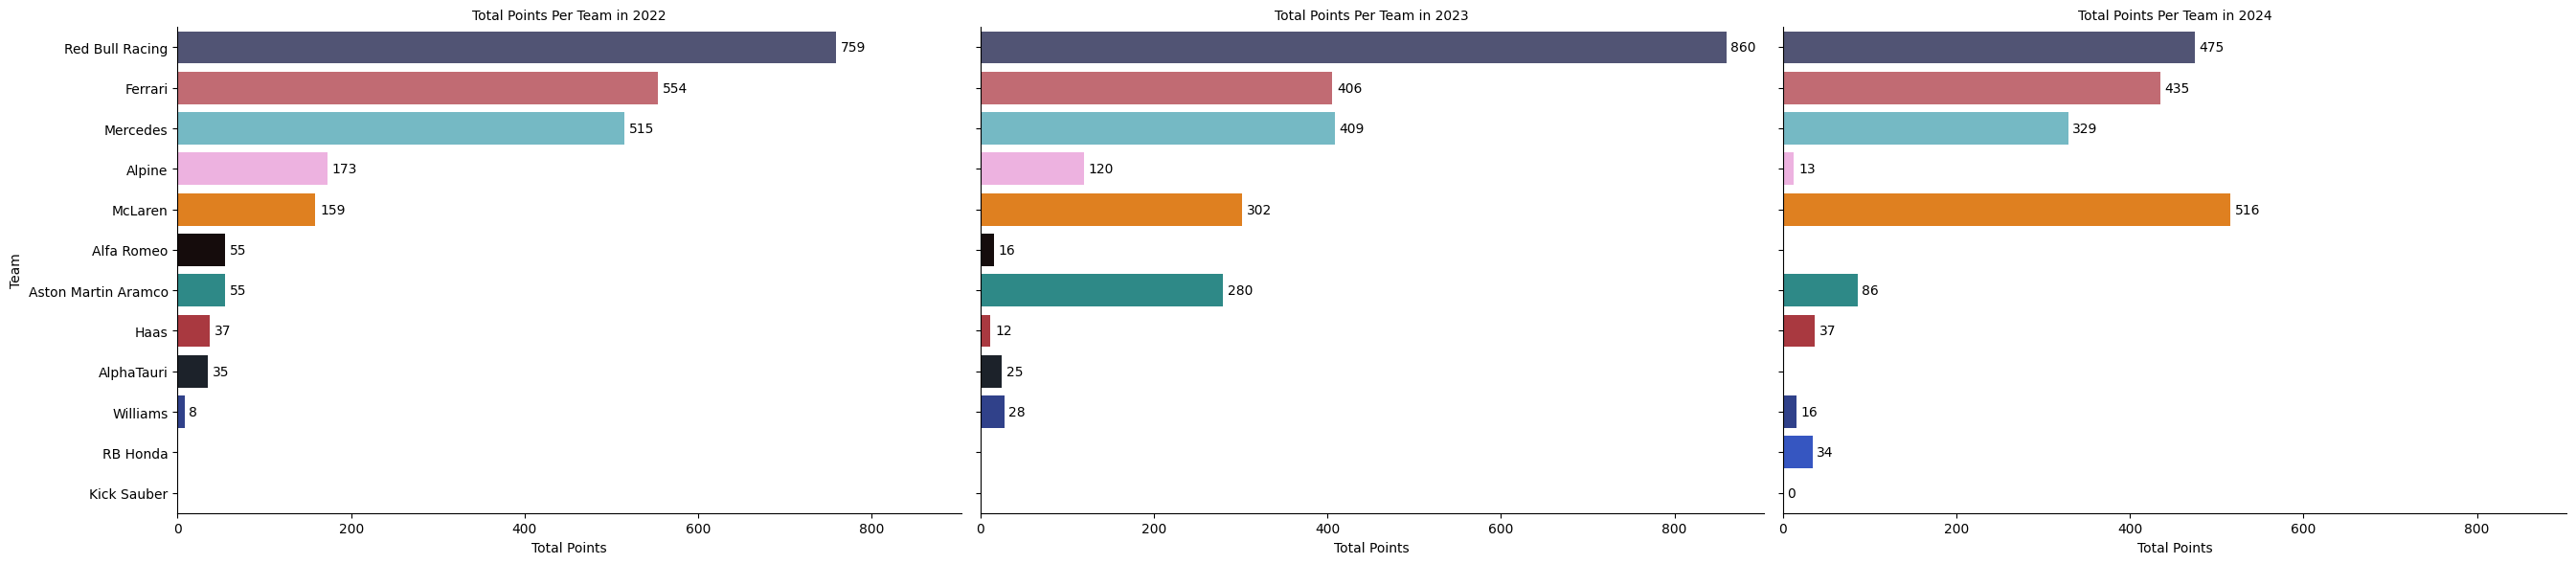

In [223]:
colour_palette = {
    'McLaren': '#FF8000',
    'Ferrari': '#cf5d67',
    'Mercedes': '#68c3d1',
    'Red Bull Racing': '#4b4f7a',
    'Aston Martin Aramco': '#1f9896',
    'Alpine': '#f7a8e5',
    'Williams': '#213799',
    'Haas': '#bc2630',
    'Alfa Romeo': '#160b0b',
    'AlphaTauri': '#1a222c',
    'RB Honda': '#1f4ad8',
    'Kick Sauber': '#3cde37'
}

# Set up a FacetGrid
g = sns.FacetGrid(wcc_2022_2024, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot, x = 'Total_Points', y = 'Car', hue = 'Car',data = wcc_2022_2024, order=wcc_2022_2024['Car'].unique(),legend = False, palette=colour_palette, errorbar = None)
            
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width (Pts value)
        if not np.isnan(width):  # Make sure width is a valid number
            ax.text(width + 5,  # Adjust the positioning of the text to offset from the bar
                    p.get_y() + p.get_height() / 2,  # Vertically center the label on the bar
                    f'{int(width)}',  # Format the text as an integer
                    va='center')  # Center the text vertically

# Adjust the titles and layout
g.set_titles("Total Points Per Team in {col_name}")
g.set_axis_labels("Total Points", "Team")
plt.tight_layout()
plt.show()

Red Bull has dominated the current set of regulations, but their dominance appears to be waning this year as Ferrari and McLaren have started to close the gap in the Constructors' Championship. The graph below illustrates how many points other teams have gained relative to Red Bull.

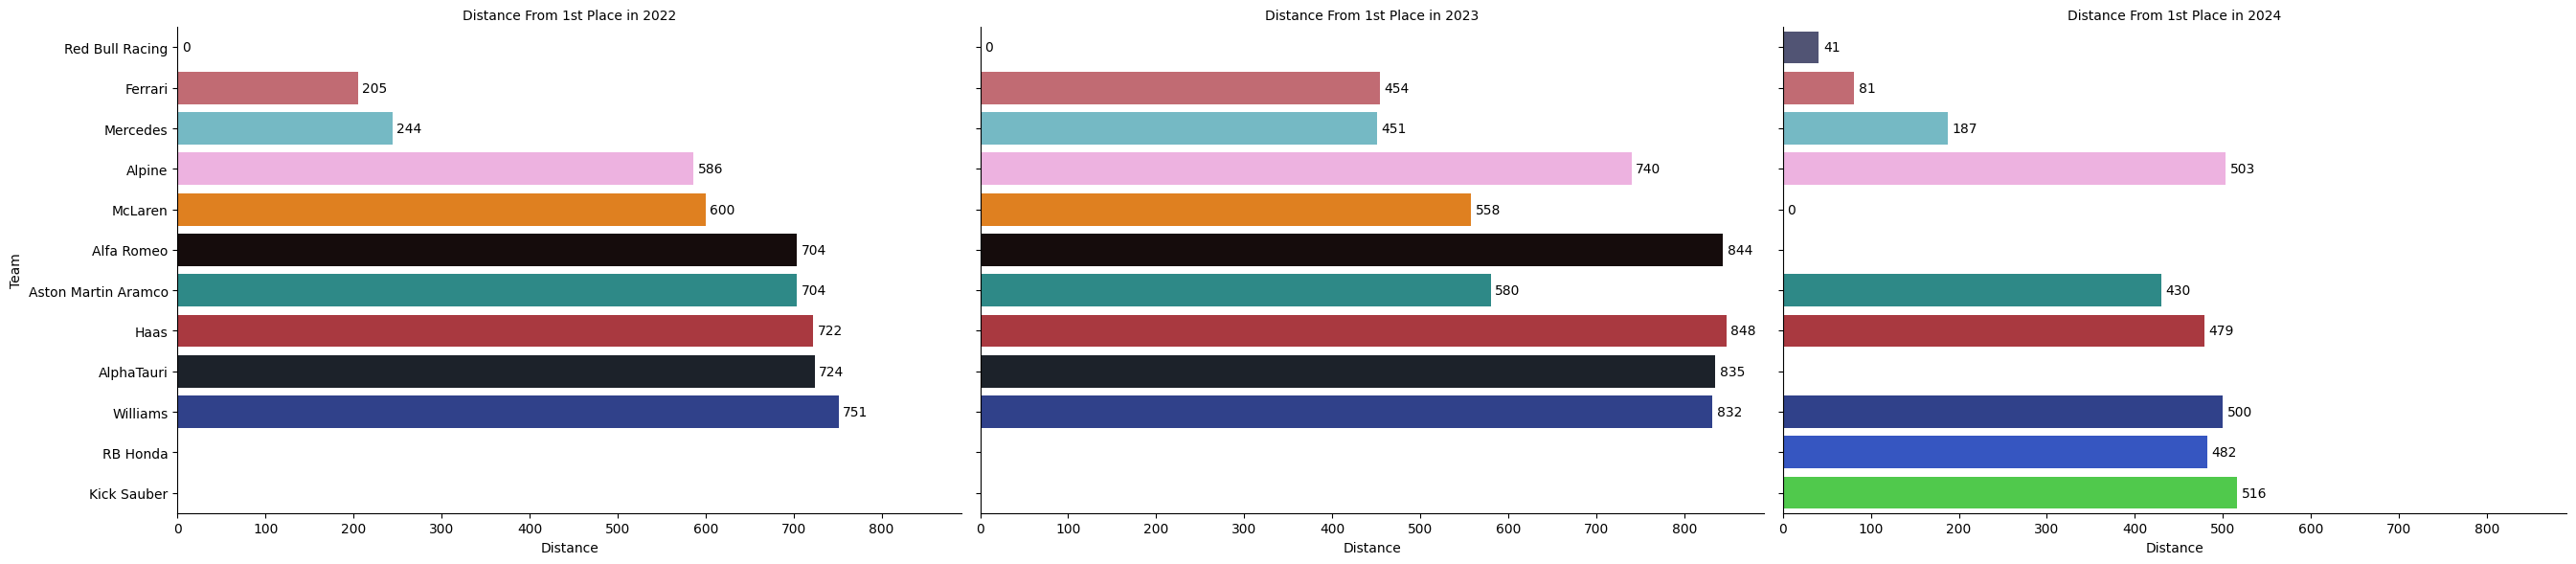

In [224]:
# Set up a FacetGrid
g = sns.FacetGrid(wcc_2022_2024, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot, data = wcc_2022_2024, x = 'Distance From First', y = 'Car', order=wcc_2022_2024['Car'].unique(), hue = 'Car', legend = False, palette = colour_palette, errorbar = None)
            
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width (Pts value)
        if not np.isnan(width):  # Make sure width is a valid number
            ax.text(width + 5,  # Adjust the positioning of the text to offset from the bar
                    p.get_y() + p.get_height() / 2,  # Vertically center the label on the bar
                    f'{int(width)}',  # Format the text as an integer
                    va='center')  # Center the text vertically
        

# Adjust the titles and layout
g.set_titles("Distance From 1st Place in {col_name}")
g.set_axis_labels("Distance", "Team")
plt.tight_layout()
plt.show()

By examining the points difference from the first-place team, we can gauge how close teams like Ferrari and McLaren are to overtaking Red Bull. It's fascinating to see the contrast over the past three years. While Red Bull clearly dominated in 2023, the competition was much closer in the other years, and this season is shaping up to be highly competitive at the top.

Next, we'll examine how many podiums the top four teams have achieved over the last three years.

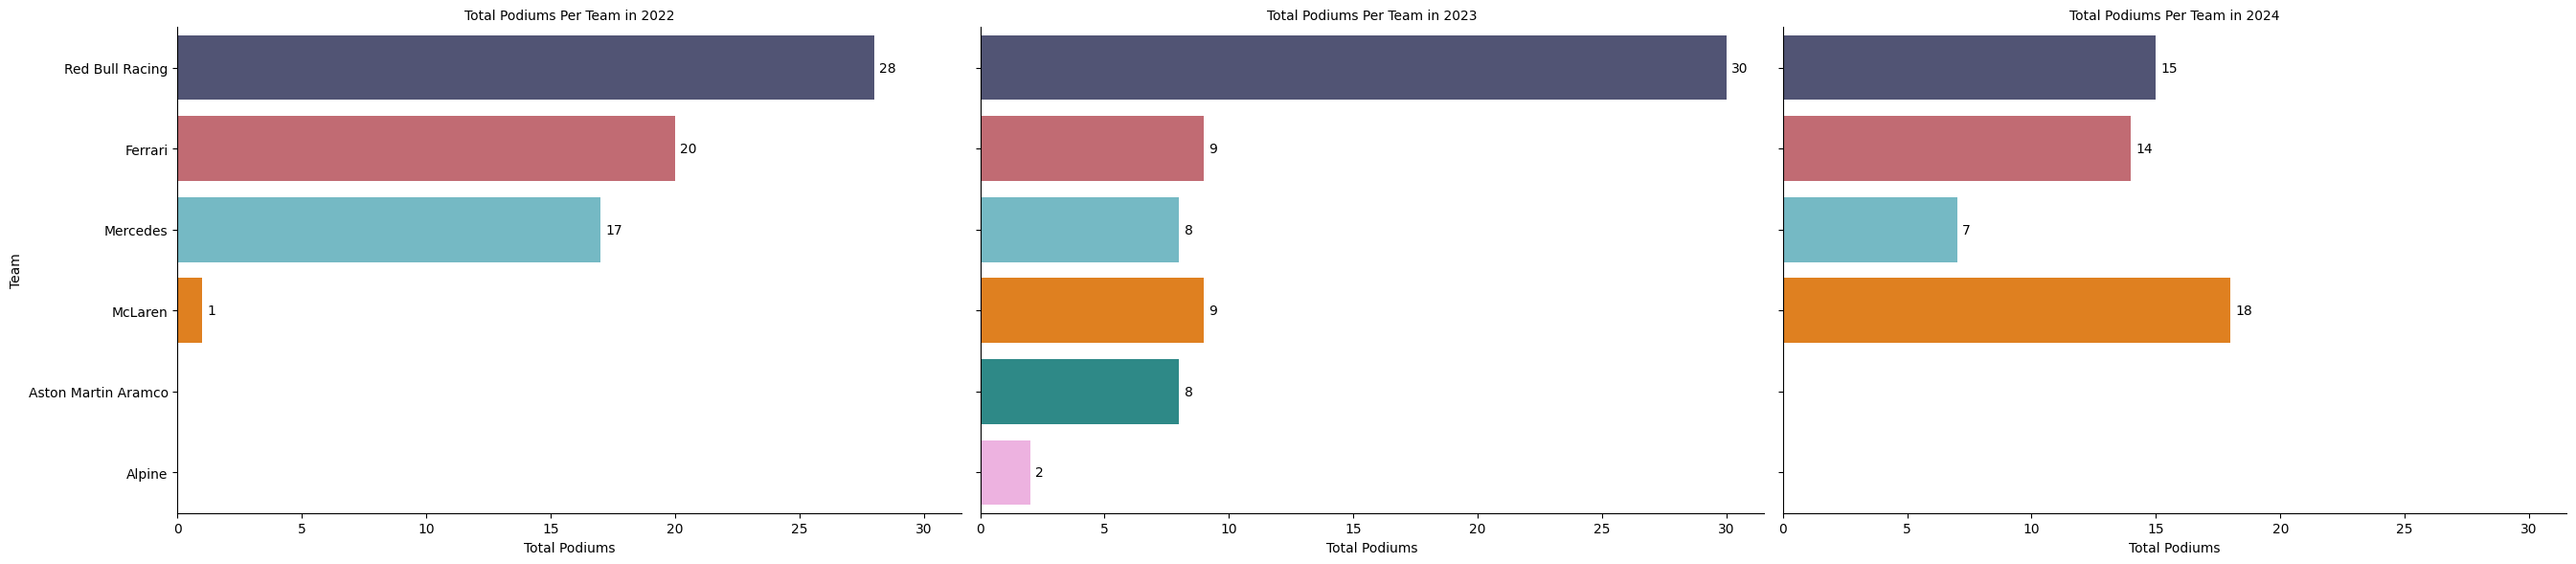

In [225]:
race_podiums_per_team = wcc_2022_2024[wcc_2022_2024['Total_Podiums'] > 0]

# Set up a FacetGrid
g = sns.FacetGrid(race_podiums_per_team, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot,data = race_podiums_per_team, x = 'Total_Podiums', y = 'Car', order=race_podiums_per_team['Car'].unique(), hue = 'Car', legend = False, palette = colour_palette, errorbar = None)

# Add labels to each bar in each facet
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width
        ax.text(width + 0.2,    # Position label slightly offset from the bar
                p.get_y() + p.get_height() / 2,  # Center label vertically on the bar
                f'{width:.0f}',   # The label text
                va='center')

# Adjust the titles and layout
g.set_titles("Total Podiums Per Team in {col_name}")
g.set_axis_labels("Total Podiums", "Team")
plt.tight_layout()
plt.show()

The following graph shows how many wins each team and driver secured throughout the current regulation period. This graph visualises how wins were distributed across teams and drivers during the regulation period. While Red Bull's dominance in 2023 is evident, McLaren's rise in 2024 suggests an evolving competitive landscape.

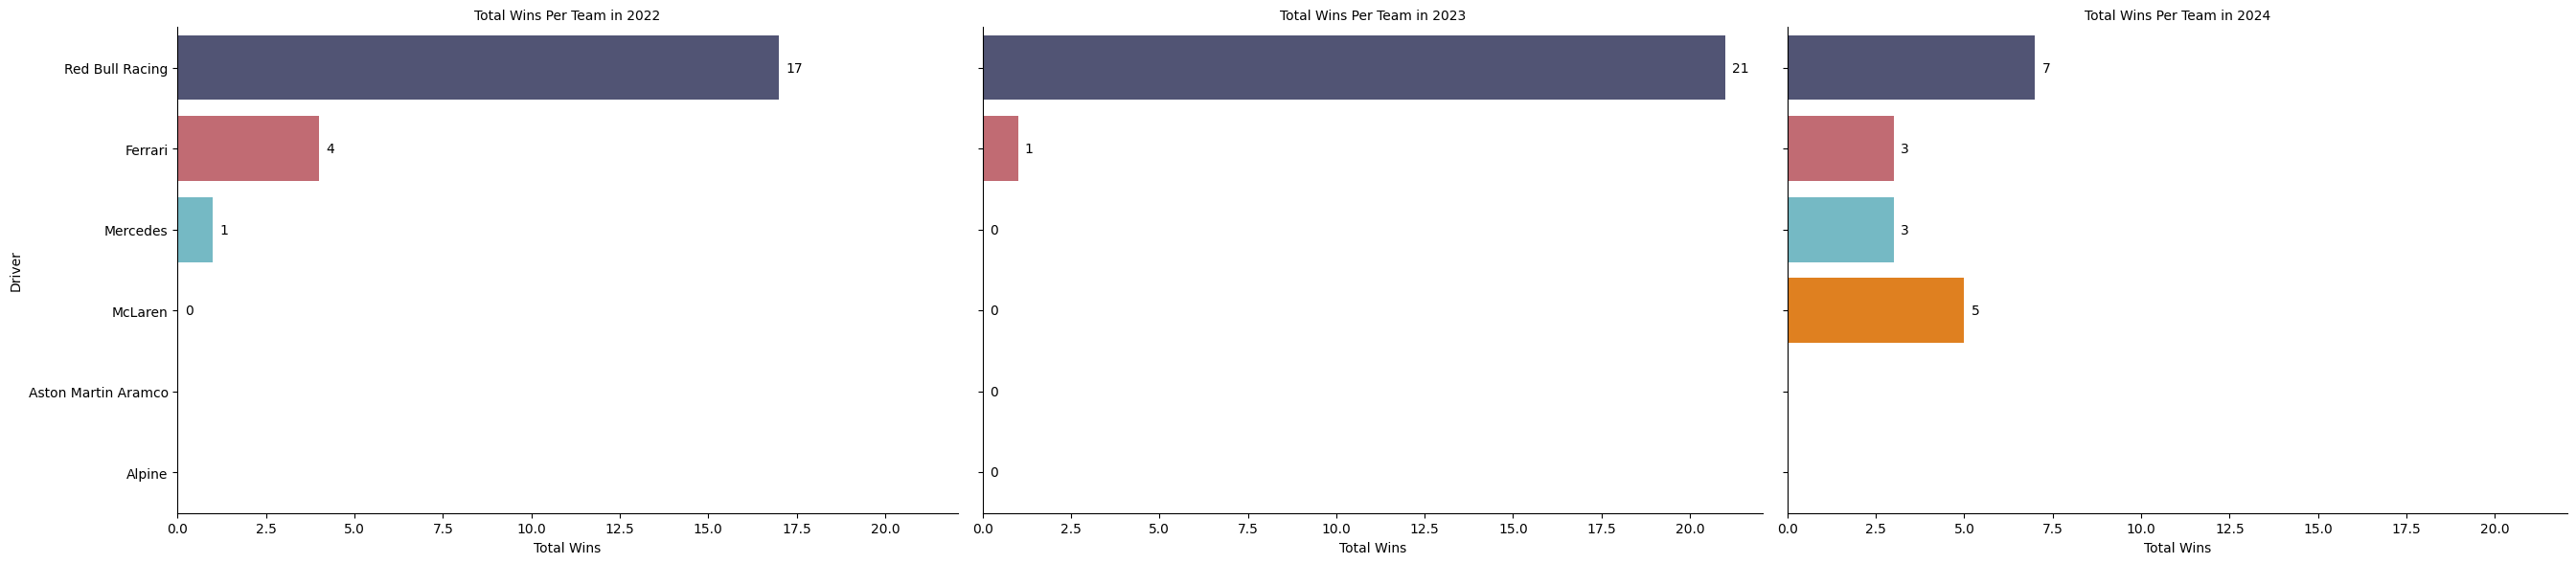

In [236]:
race_winners = wdc_2022_2024[wdc_2022_2024['Total Wins'] > 0]

# Set up a FacetGrid
g = sns.FacetGrid(race_podiums_per_team, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot,data = race_podiums_per_team, x = 'Total_Wins', y = 'Car', order=race_podiums_per_team['Car'].unique(), hue = 'Car', legend = False, palette = colour_palette, errorbar = None)

# Add labels to each bar in each facet
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width
        ax.text(width + 0.2,    # Position label slightly offset from the bar
                p.get_y() + p.get_height() / 2,  # Center label vertically on the bar
                f'{width:.0f}',   # The label text
                va='center')

# Adjust the titles and layout
g.set_titles("Total Wins Per Team in {col_name}")
g.set_axis_labels("Total Wins", "Driver")
plt.tight_layout()
plt.show()

The graph below illustrates the points accumulated by the top four teams each year. As expected, Red Bull surged ahead in 2022 and, more dramatically, in 2023, leaving Mercedes and Ferrari to battle for the remainder. McLaren's remarkable comeback in 2023 is a standout narrative of this regulation period. By pinpointing key upgrades (e.g. a new floor at the Azerbaijan Grand Prix), we can see how their performance trajectory changed, allowing them to challenge the front-runners.

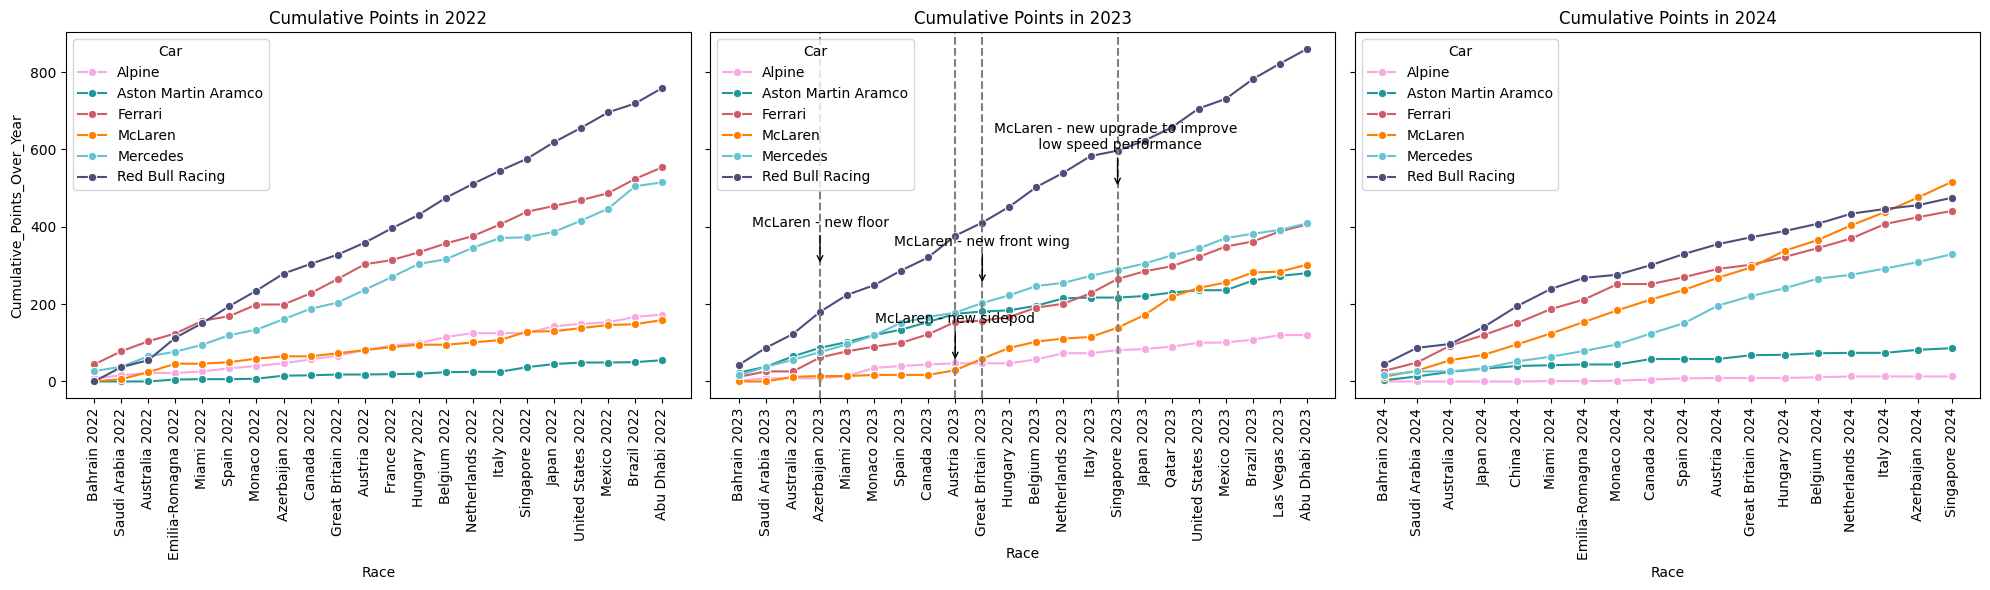

In [227]:
key_races = ['Azerbaijan 2023', 'Austria 2023', 'Great Britain 2023', 'Singapore 2023']
events = ['McLaren - new floor', 'McLaren - new sidepod','McLaren - new front wing', 'McLaren - new upgrade to improve \n low speed performance']

y_positions = [300, 50, 250, 500]  # Custom Y positions for each event
rotations = [0, 0, 0, 0, 0]  # Custom rotation angles for each annotation

aggregated_race_results['Race'] = aggregated_race_results['Circuit'] + ' ' + aggregated_race_results['Year'].astype(str)
mclaren = aggregated_race_results[aggregated_race_results['Car'].isin(race_podiums_per_team['Car'])]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)  # 1 row, 3 columns, sharing the y-axis

# Define years you want to plot
years = [2022, 2023, 2024]

# Loop through each year and create separate line plots
for i, year in enumerate(years):
    # Filter data for the current year
    year_data = mclaren[mclaren['Year'] == year]
    
    # Create the line plot for the current year
    sns.lineplot(data=year_data, x='Race', y='Cumulative_Points_Over_Year', hue='Car', palette = colour_palette, marker='o', ax=axes[i])
    
    # Set the title for the subplot
    axes[i].set_title(f'Cumulative Points in {year}')
    
    # Rotate x-ticks for better readability
    axes[i].tick_params(axis='x', rotation=90)

    if year == 2023:
        for race, event,y_pos in zip(key_races, events,y_positions):
            axes[i].axvline(x=race, color='grey', linestyle='--', ymin=0, ymax=1)  # Add vertical line
            axes[i].annotate(event, xy=(race, y_pos), xytext=(race, y_pos + 100),  # Adjust y position as needed
                             arrowprops=dict(facecolor='black', arrowstyle='->'),
                             horizontalalignment='center', rotation=0)  # Customise rotation

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

2023 was a pivotal year for McLaren. They made a bold move by replacing the experienced Daniel Ricciardo with rising talent Oscar Piastri, hoping to solidify their driver line-up for years to come. Additionally, the team recognised that their car’s development path was flawed and made the decision to start over, beginning with the introduction of a new floor at the Azerbaijan Grand Prix. While the new floor did not yield immediate results, it provided a strong foundation for further upgrades later in the season. This gamble paid off, as by Austria 2023, McLaren consistently found themselves in contention for podium finishes. However, it was Mercedes' consistency that ultimately secured them second place in the Constructors' Championship for the season.

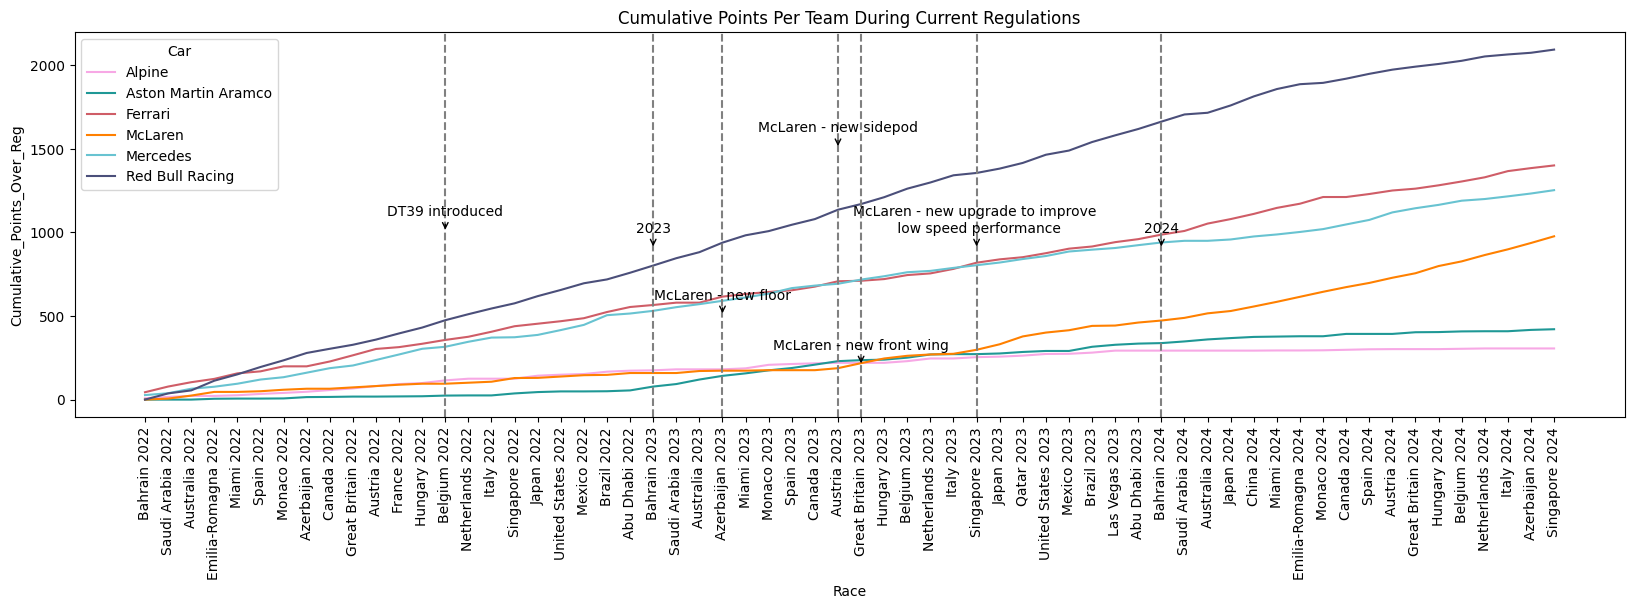

In [228]:
key_races = ['Belgium 2022', 'Bahrain 2023', 'Azerbaijan 2023', 'Austria 2023', 'Great Britain 2023', 'Singapore 2023', 'Bahrain 2024']
events = ['DT39 introduced', '2023', 'McLaren - new floor', 'McLaren - new sidepod','McLaren - new front wing', 'McLaren - new upgrade to improve \n low speed performance', '2024']

y_positions = [1000, 900, 500, 1500, 200, 900, 900]  # Custom Y positions for each event
rotations = [0, 0, 0, 0, 0, 0, 0]  # Custom rotation angles for each annotation

plt.figure(figsize= (20, 5))

sns.lineplot(data = mclaren,x = 'Race', y = 'Cumulative_Points_Over_Reg',hue = 'Car', palette = colour_palette)

for race, event, y_pos, rotation in zip(key_races, events, y_positions, rotations):
    plt.axvline(x=race, color='grey', linestyle='--', ymin=0, ymax=1)  # Add vertical line
    plt.annotate(event, xy=(race, y_pos), xytext=(race, y_pos + 100),  # Adjust y position
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 horizontalalignment='center', rotation=rotation)  # Customise rotation

plt.title('Cumulative Points Per Team During Current Regulations')

plt.xticks(rotation = 90)

plt.show()

This graph is similar to the previous one, but it illustrates the points accumulated over the entire regulation period. As expected, it reinforces the key trends: Red Bull's dominance throughout the current regulation era, McLaren's remarkable comeback beginning at the Austria 2023 Grand Prix, and the ongoing battle between Ferrari and Mercedes.

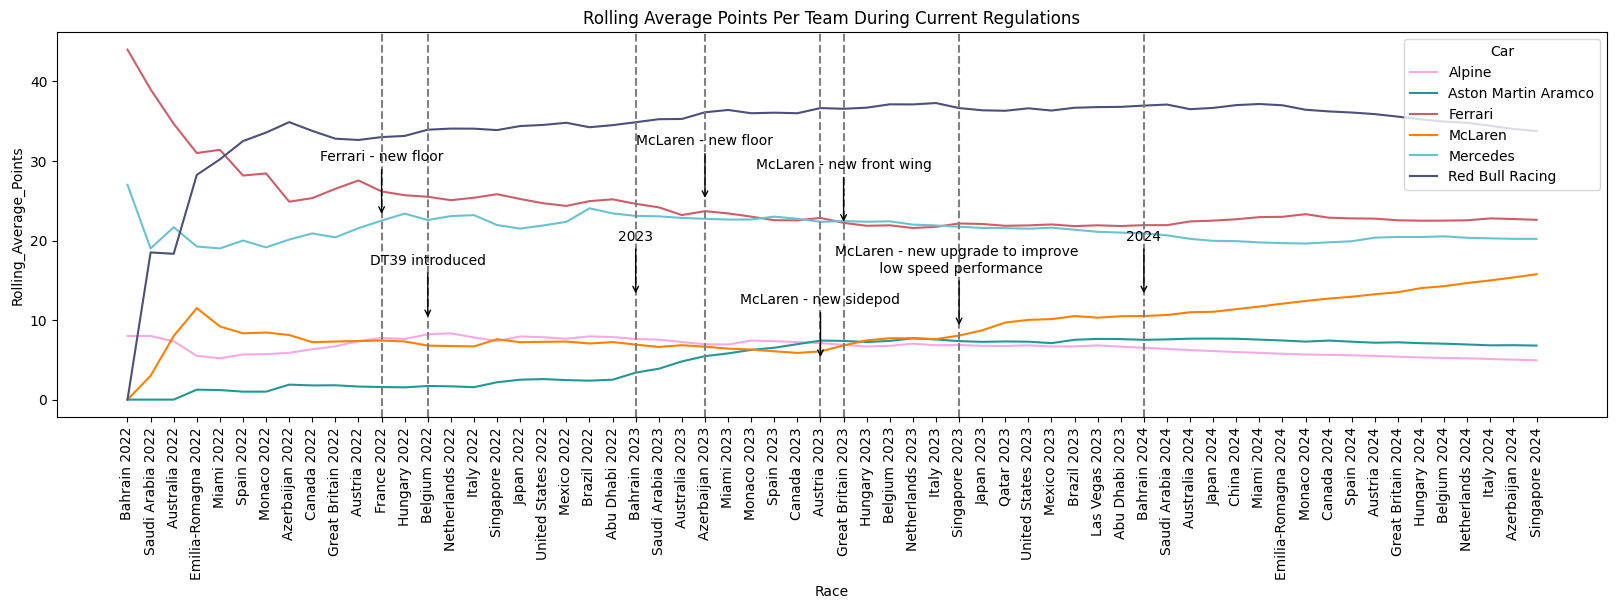

In [229]:
key_races = ['France 2022', 'Belgium 2022', 'Bahrain 2023', 'Azerbaijan 2023', 'Austria 2023', 'Great Britain 2023', 'Singapore 2023', 'Bahrain 2024']
events = ['Ferrari - new floor', 'DT39 introduced', '2023', 'McLaren - new floor', 'McLaren - new sidepod','McLaren - new front wing', 'McLaren - new upgrade to improve \n low speed performance', '2024']

y_positions = [23, 10, 13, 25, 5, 22, 9, 13]  # Custom Y positions for each event
rotations = [0, 0, 0, 0, 0, 0, 0, 0]  # Custom rotation angles for each annotation

plt.figure(figsize= (20, 5))

sns.lineplot(data = mclaren,x = 'Race', y = 'Rolling_Average_Points',hue = 'Car', palette = colour_palette)

for race, event, y_pos, rotation in zip(key_races, events, y_positions, rotations):
    plt.axvline(x=race, color='grey', linestyle='--', ymin=0, ymax=1)  # Add vertical line
    plt.annotate(event, xy=(race, y_pos), xytext=(race, y_pos + 7),  # Adjust y position
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 horizontalalignment='center', rotation=rotation)  # Customise rotation

plt.title('Rolling Average Points Per Team During Current Regulations')

plt.xticks(rotation = 90)

plt.show()

This graph illustrates the average points accumulated per team over the regulation period. The year 2022 was particularly intriguing because, although it's not fully captured here, Ferrari was relatively close to Red Bull at the start of the season. However, the introduction of a new technical directive at the Belgium Grand Prix aimed at tackling porpoising (the bouncing effect caused by ground-effect aerodynamics) altered the dynamics. While this directive wasn’t solely responsible for Ferrari's decline, it was considered a contributing factor, along with the floor upgrade they introduced in France.

It also highlights McLaren's resurgence from the Austrian Grand Prix in 2023. While having a strong driver line-up is undoubtedly crucial, the car’s performance is the primary factor, and McLaren's shift in design philosophy for 2023 proved to be pivotal. It could have easily gone wrong, but the gamble paid off. Although they didn’t start the regulation period as planned, they now look poised to finish on a high, potentially winning the Constructors' Championship and challenging for the Drivers' Championship.

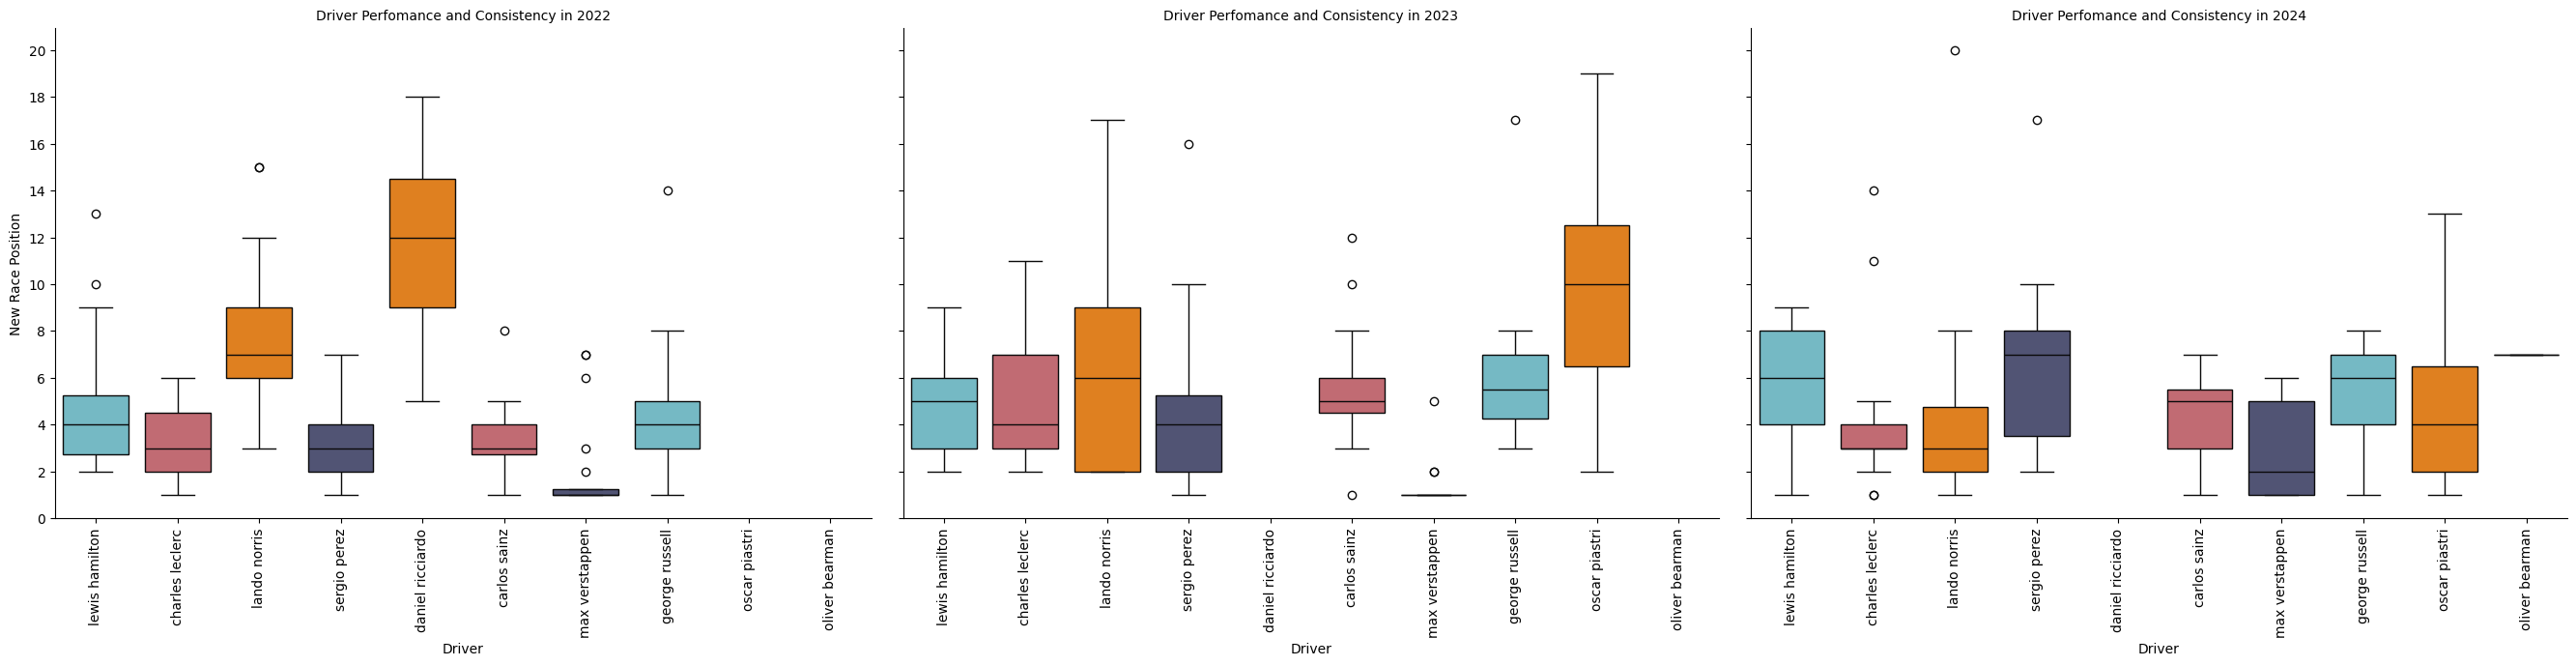

In [232]:
race_winners_results = driver_race_results[driver_race_results['Car'].isin(race_winners['Car'])]

g = sns.FacetGrid(race_winners_results, col="Year", height=6, aspect=1.5)
g.map_dataframe(sns.boxplot, x="Driver", y="New Race Position", hue = 'Car', palette = colour_palette)
plt.yticks(np.arange(0, 21, 2))
g.set_titles("Driver Perfomance and Consistency in {col_name}")
g.set_xticklabels(rotation=90)
plt.show()

The graph above highlights the race performance consistency of drivers from the top four teams across the 2022, 2023, and 2024 seasons. Max Verstappen demonstrates the highest level of consistency, with a very tight distribution around the top positions, indicating exceptional performance and minimal variation.

Lando Norris and Oscar Piastri show significant improvement across the three seasons. Norris’ race position spread narrows, and his average race position improves, signaling growing consistency and better results over time. Piastri, despite improvements, still displays a wider spread in 2024, suggesting room for more consistent race results, which aligns with observations on track. Overall it shows that no matter how powerful the car is, driver consistency is key to winning the championship.

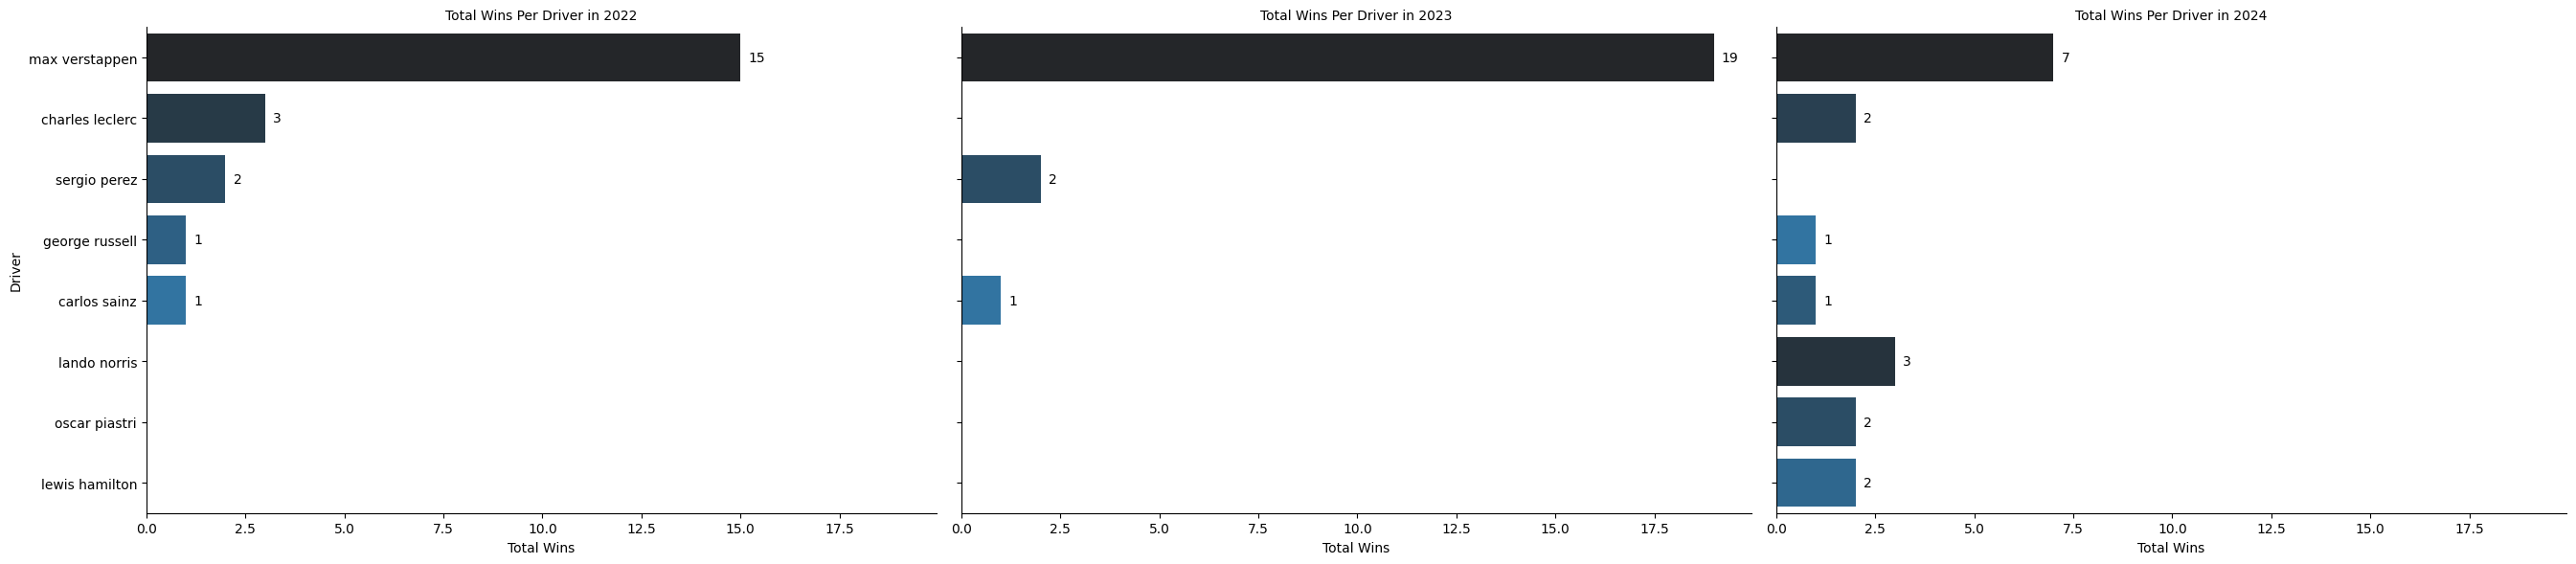

In [238]:
# Set up a FacetGrid
g = sns.FacetGrid(race_winners, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot,data = race_winners, x = 'Total Wins', y = 'Driver', order=race_winners['Driver'].unique(), hue = 'Driver', legend = False,palette='dark:#1f77b4', errorbar = None)

# Add labels to each bar in each facet
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width
        ax.text(width + 0.2,    # Position label slightly offset from the bar
                p.get_y() + p.get_height() / 2,  # Center label vertically on the bar
                f'{width:.0f}',   # The label text
                va='center')

# Adjust the titles and layout
g.set_titles("Total Wins Per Driver in {col_name}")
g.set_axis_labels("Total Wins", "Driver")
plt.tight_layout()
plt.show()

This section highlights the extent of Red Bull's dominance, especially through Max Verstappen, in 2022 and 2023. For further context, Verstappen holds the record for the most races won in a single year and the second-highest number of races won in another season, with a win percentage of 68.2% and 86.2%, respectively. It's equally remarkable how quickly other teams have closed the gap this year. The last time four different teams won a race was in 2021, and to find a season where seven different drivers claimed victories, you’d have to go back to 2012.

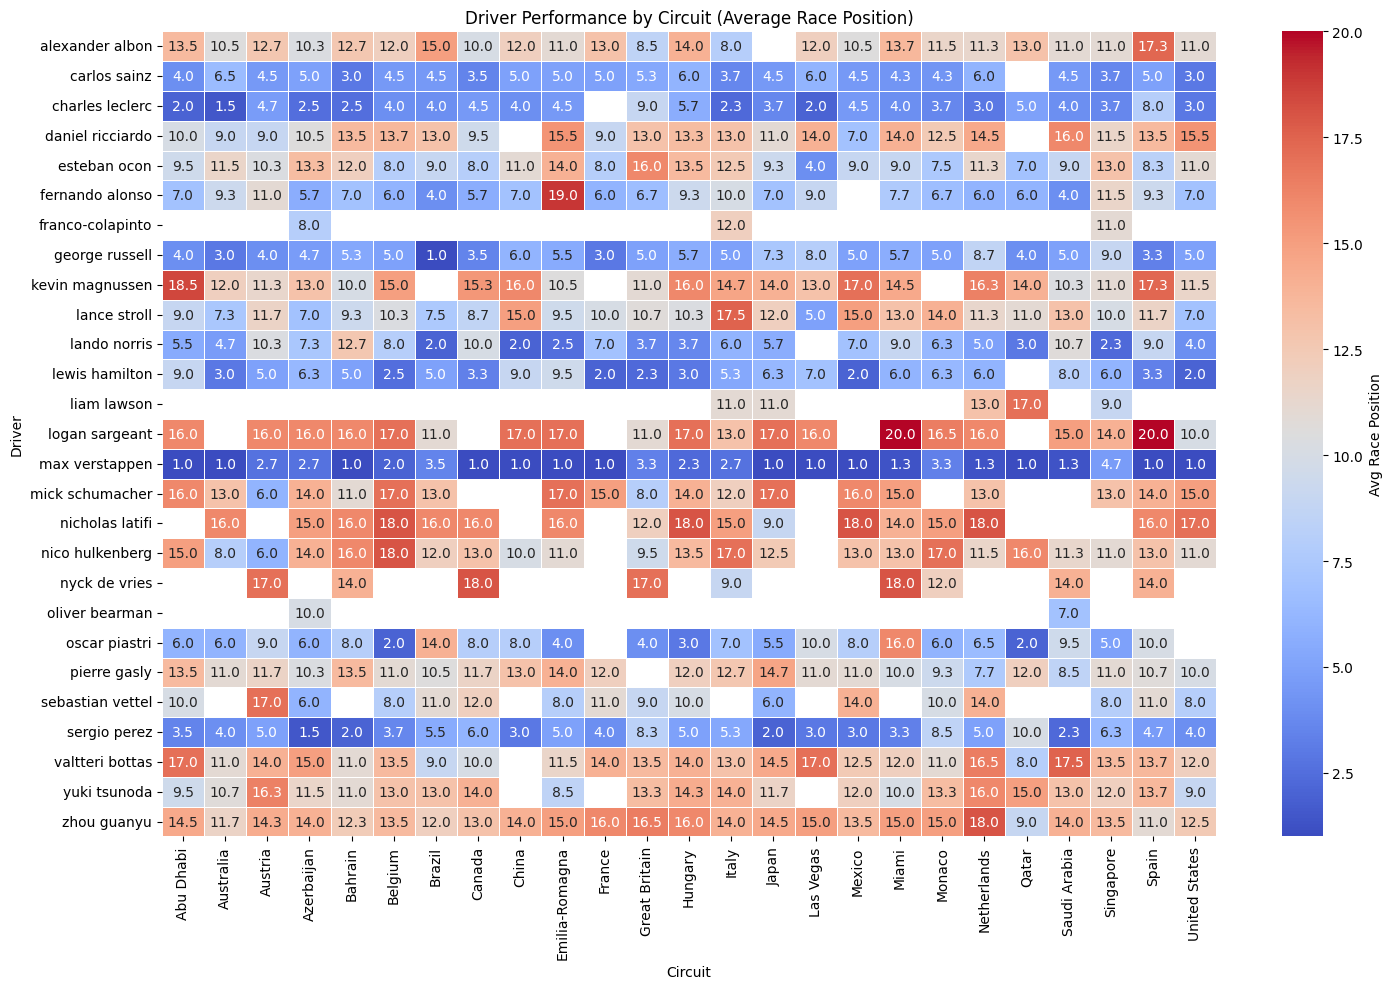

In [234]:
driver_circuit_performance = driver_race_results.groupby(['Driver', 'Circuit']).agg(
    avg_race_position=('New Race Position', 'mean')
).reset_index()

# Step 2: Pivot the table to create a matrix of drivers vs circuits
heatmap_data = driver_circuit_performance.pivot(index='Driver', columns='Circuit', values='avg_race_position')

# Step 3: Create the heatmap
plt.figure(figsize=(15, 10))  # Adjust the figure size for better visibility
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5, fmt='.1f', cbar_kws={'label': 'Avg Race Position'})
plt.title('Driver Performance by Circuit (Average Race Position)')
plt.xlabel('Circuit')
plt.ylabel('Driver')
plt.xticks(rotation=90)  # Rotate the circuit names for better readability
plt.tight_layout()  # Ensure the plot fits well
plt.show()

The heatmap illustrates the average race positions of drivers across different circuits, regardless of the year, to showcase their overall performance at each venue. Drivers like Max Verstappen and Lewis Hamilton consistently performed well across most circuits, as indicated by their lower average race positions (darker blue cells), reflecting strong adaptability and comfort at various tracks.

On the other hand, drivers such as Logan Sargeant and Mick Schumacher have higher average positions (red cells), showing struggles or less favorable performance across multiple circuits. The heatmap also highlights the circuits where certain drivers tend to excel, such as Max Verstappen in circuits like Austria and Japan, whereas others show more varied results.